In [ ]:
!pip install meshio==5.0.4
!pip install pyevtk
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import torch
import torch.utils.data as Data
import meshio
import time
import copy
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
from pyevtk.hl import pointsToVTK

seed=529
# results should be reproducible
def setup_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic=True
  torch.backends.cudnn.benchmark = False
setup_seed(seed)
# CUDA acceleration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cuda


# Pre-processing

[<meshio CellBlock, type: quad, num cells: 7644>]
Number of FEM elements:  7644     Number of FEM nodes:  8232


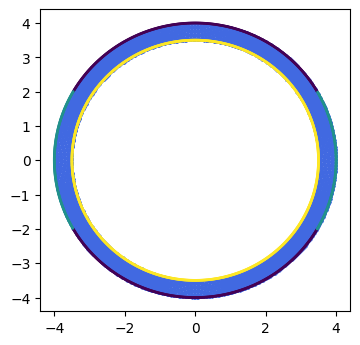

'/content/2Dring_2f_surface.vtu'

In [ ]:
# read the meshgrid from Abaqus .inp file
setup_seed(seed)
mesh = meshio.abaqus.read('/content/drive/MyDrive/2Dring/Job-2.inp')
points = mesh.points
print(mesh.cells)
cells = mesh.cells[0][1]
print('Number of FEM elements: ', cells.shape[0], '    Number of FEM nodes: ', points.shape[0])
# use the node points from FEM as collocation points
train_points = points

# surface points generation function
def PointsInSurface(radius=8.0/2.0, ox=0.0, oy=0.0, alpha1=0, alpha2=360, nrad=20, thick=1.0, nthick=1, ntype=1):
  linepoints = [(ox + np.cos((alpha2-alpha1)/360*2*np.pi/nrad*x + alpha1/360*2*np.pi)*radius, oy + np.sin((alpha2-alpha1)/360*2*np.pi/nrad*x + alpha1/360*2*np.pi)*radius) for x in range(0,nrad)]
  surfpoints = np.tile(linepoints, (nthick, 1))
  linenorm = [(np.cos((alpha2-alpha1)/360*2*np.pi/nrad*x + alpha1/360*2*np.pi), np.sin((alpha2-alpha1)/360*2*np.pi/nrad*x + alpha1/360*2*np.pi), 0.0) for x in range(0,nrad)]
  surfnorm = np.tile(linenorm, (nthick, 1))
  z = np.tile(np.linspace(0, thick, num=nthick), (nrad, 1)).T
  z = z.reshape(-1,1)
  pointtype = np.ones(nrad*nthick)*ntype
  pointtype = pointtype.reshape(-1,1)
  surf = np.hstack((surfpoints, z, surfnorm, pointtype))
  return surf

# generate the outer BC points
SurfP1 = np.vstack((PointsInSurface(alpha1=30, alpha2=150, nrad=400, ntype=1), PointsInSurface(alpha1=210, alpha2=330, nrad=400, ntype=1)))
SurfP2 = np.vstack((PointsInSurface(alpha1=0.0, alpha2=30, nrad=100, ntype=2), PointsInSurface(alpha1=150, alpha2=210, nrad=200, ntype=2), PointsInSurface(alpha1=330, alpha2=360, nrad=100, ntype=2)))

# generate the inner BC points
SurfFr = np.vstack((PointsInSurface(radius=8.0/2.0-0.5, nrad=1200, ntype=3)))
# inverse the norm vector direction
SurfFr[:, 3] *= -1
SurfFr[:, 4] *= -1

# surface plot
Surf = np.vstack((SurfP1, SurfP2, SurfFr))
plt.figure(figsize=(4,4), dpi=100)
plt.scatter(train_points[:,0], train_points[:, 1], s=1, c='royalblue')
plt.scatter(Surf[:, 0], Surf[:, 1], s=1, c=Surf[:,6])
plt.show()
pointsToVTK("./2Dring_2f_surface", np.ascontiguousarray(Surf[:,0]), np.ascontiguousarray(Surf[:,1]), np.ascontiguousarray(Surf[:,2]), data={"type": np.ascontiguousarray(Surf[:,6])})

# Neural network

In [ ]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # initialization function
        #def init_weights(m):
        #    if type(m) == torch.nn.Linear:
        #    torch.nn.init.xavier_uniform_(m.weight)
        #    torch.nn.init.normal_(m.bias)
        
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(2, 30),
            torch.nn.Tanh(),
            torch.nn.Linear(30, 30),
            torch.nn.Tanh(),
            torch.nn.Linear(30, 30),
            torch.nn.Tanh(),
            torch.nn.Linear(30, 30),
            torch.nn.Tanh(),
            torch.nn.Linear(30, 30),
            torch.nn.Tanh(),
            torch.nn.Linear(30, 2)
        )

        # recursively apply the initialization
        #self.layers.apply(init_weights)
    
    def forward(self, x):
        out = self.layers(x)
        return out

class AutomaticWeightedLoss(torch.nn.Module):
    def __init__(self, num=2):
        super(AutomaticWeightedLoss, self).__init__()
        params = torch.ones(num, requires_grad=True)
        self.params = torch.nn.Parameter(params)

    def forward(self, *x):
        loss_sum = 0
        for i, loss in enumerate(x):
            loss_sum += 0.5 / (self.params[i] ** 2) * loss + torch.log(1 + self.params[i] ** 2)
        return loss_sum

In [ ]:
setup_seed(seed)
material=dict()
material['mo'] = 30000000000
material['nu'] = 0.2
lame1 = material['mo']*material['nu']/(1+material['nu'])/(1-2.0*material['nu'])
lame2 = material['mo']/((1+material['nu'])*2)
beta = lame1/lame2

# scaling factors
l_c = 4.0
u_c = 0.0026
sigma_c = lame2*u_c/l_c
print('beta', beta)
print('l_c', l_c)
print('u_c', u_c)
print('sigma_c', sigma_c)

# np2tensor
x_int = torch.tensor(train_points[:,0:1]/l_c, requires_grad=True).float().to(device)
y_int = torch.tensor(train_points[:,1:2]/l_c, requires_grad=True).float().to(device)

x_e1 = torch.tensor(SurfP1[:,0:1]/l_c, requires_grad=True).float().to(device)
y_e1 = torch.tensor(SurfP1[:,1:2]/l_c, requires_grad=True).float().to(device)

x_e2 = torch.tensor(SurfP2[:,0:1]/l_c, requires_grad=True).float().to(device)
y_e2 = torch.tensor(SurfP2[:,1:2]/l_c, requires_grad=True).float().to(device)

x_fr = torch.tensor(SurfFr[:,0:1]/l_c, requires_grad=True).float().to(device)
y_fr = torch.tensor(SurfFr[:,1:2]/l_c, requires_grad=True).float().to(device)

x_n1 = torch.tensor(SurfP1[:,3:4]).float().to(device)
y_n1 = torch.tensor(SurfP1[:,4:5]).float().to(device)

x_n2 = torch.tensor(SurfP2[:,3:4]).float().to(device)
y_n2 = torch.tensor(SurfP2[:,4:5]).float().to(device)

x_nfr = torch.tensor(SurfFr[:,3:4]).float().to(device)
y_nfr = torch.tensor(SurfFr[:,4:5]).float().to(device)

# Get Abaqus .odb results
"""
# This code can be directly used in Abaqus Kernel Command Link Interface
from odbAccess import*
from abaqusConstants import*
import os

odb=openOdb('.\Job-2f.odb')
RS=odb.steps['Step-1'].frames[-1].fieldOutputs['U']

outputfile=open('FEM_displacement_2f.txt','w')
for i in RS.values:
    outputfile.write('%d %7.5f %7.5f\n' % (i.nodeLabel,i.data[0],i.data[1]))
else:
    outputfile.close()
    
# Reference links:
# https://www.cnblogs.com/gaozihan/p/12617928.html
# http://130.149.89.49:2080/v2016/books/cmd/default.htm?startat=pt05ch09s05.html#cmd-odb-intro-read-node-pyc
"""
# Compare with the results from Abaqus
FEM_U = np.genfromtxt('/content/drive/MyDrive/2Dring/FEM_displacement_2f.txt', dtype = float)
exact_u = torch.tensor(FEM_U[:,1:2]/u_c).float().to(device)
exact_v = torch.tensor(FEM_U[:,2:3]/u_c).float().to(device)

# noisy obesrvational data
noise_x = 0.00005*np.random.normal(0, 1, 8232)
noise_y = 0.00010*np.random.normal(0, 1, 8232)
KRG_U = np.genfromtxt('/content/drive/MyDrive/2Dring/kriging_2f_field.txt', dtype = float)
noise_u = torch.tensor(FEM_U[:,1:2]/u_c+noise_x.reshape((-1,1))/u_c).float().to(device)
noise_v = torch.tensor(FEM_U[:,2:3]/u_c+noise_y.reshape((-1,1))/u_c).float().to(device)

print('Xdisp-error: %.3e' %( torch.sqrt( torch.sum((noise_u-exact_u)**2) / torch.sum(exact_u**2) ) ))
print('Ydisp-error: %.3e' %( torch.sqrt( torch.sum((noise_v-exact_v)**2) / torch.sum(exact_v**2) ) ))

# NN
model = Net().to(device)
awl = AutomaticWeightedLoss(4)
# learnable parameters
P = torch.ones(2, requires_grad=True).to(device)
P = torch.nn.Parameter(P).to(device)
# Adam
optimizer = torch.optim.Adam([
                {'params': model.parameters(), 'lr': 0.001},
                {'params': awl.parameters(), 'lr': 0.0001},
                {'params': P, 'lr': 0.001}
                ])

def net_out(x, y): 
    # concatenates tensor x and y，dim=1 means hstack, because dimension of the DNN input layer is N*2
    input = torch.cat([x, y], dim=1)
    out = model(input)
    u = out[:,0:1]
    v = out[:,1:2]
    return u, v

def net_derivative(x, y): 
    u, v = net_out(x, y)
    # automatic differentiation
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    
    v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
    v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
    
    e_xy = u_y + v_x
    
    # claculate stress
    sxx = beta*(u_x+v_y) + 2*u_x
    syy = beta*(u_x+v_y) + 2*v_y
    sxy = 1*e_xy
    sxx_x = torch.autograd.grad(sxx, x, grad_outputs=torch.ones_like(sxx), retain_graph=True, create_graph=True)[0]
    sxy_y = torch.autograd.grad(sxy, y, grad_outputs=torch.ones_like(sxy), retain_graph=True, create_graph=True)[0]
    
    sxy_x = torch.autograd.grad(sxy, x, grad_outputs=torch.ones_like(sxy), retain_graph=True, create_graph=True)[0]
    syy_y = torch.autograd.grad(syy, y, grad_outputs=torch.ones_like(syy), retain_graph=True, create_graph=True)[0]
    
    return sxx_x, sxy_y, sxy_x, syy_y

def net_trac(x, y, nx, ny): 
    u, v = net_out(x, y)
    # automatic differentiation
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    
    v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
    v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
    
    e_xy = u_y + v_x
    
    # claculate stress
    sxx = beta*(u_x+v_y) + 2*u_x
    syy = beta*(u_x+v_y) + 2*v_y
    sxy = 1*e_xy
    # calculate traction
    tx = sxx*nx + sxy*ny
    ty = sxy*nx + syy*ny
    trac_n = tx*nx + ty*ny
    trac_t = tx**2+ty**2-trac_n**2
    return trac_n, trac_t

def net_stress(x, y): 
    u, v = net_out(x, y)
    # automatic differentiation
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    
    v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
    v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
    
    e_xy = u_y + v_x
    
    # claculate stress
    sxx = beta*(u_x+v_y) + 2*u_x
    syy = beta*(u_x+v_y) + 2*v_y
    sxy = 1*e_xy
    return sxx, syy, sxy

beta 0.6666666666666667
l_c 4.0
u_c 0.0026
sigma_c 8125000.0
Xdisp-error: 1.255e-01
Ydisp-error: 9.757e-02


In [ ]:
%%time
setup_seed(seed)
model.train()

num_train_its=100001
Loss_list = []
Loss_g = []
Loss_i = []
Loss_e1 = []
Loss_e2 = []
Loss_data = []
Loss_true = []
P1 = []
P2 = []

for epoch in range(num_train_its):
  u_net, v_net = net_out(x_int, y_int)

  sxx_x_net, sxy_y_net, sxy_x_net, syy_y_net = net_derivative(x_int, y_int)

  trac_n_e1, trac_t_e1 = net_trac(x_e1, y_e1, x_n1, y_n1)
  trac_n_e2, trac_t_e2 = net_trac(x_e2, y_e2, x_n2, y_n2)
  trac_n_fr, trac_t_fr = net_trac(x_fr, y_fr, x_nfr, y_nfr)

  # Loss
  loss_data = ( (u_net-noise_u)**2 ).mean() + ( (v_net-noise_v)**2 ).mean()
  loss_pde = ( (sxx_x_net+sxy_y_net)**2 ).mean() + ( (sxy_x_net+syy_y_net)**2 ).mean()
  loss_fr = ( trac_n_fr**2 ).mean() + ( trac_t_fr ).mean()
  loss_P1 = ( (trac_n_e1 + 100000*P[0]/sigma_c )**2 ).mean() + ( trac_t_e1 ).mean()
  loss_P2 = ( (trac_n_e2 + 100000*P[1]/sigma_c )**2 ).mean() + ( trac_t_e2 ).mean()
  loss_true = ( (u_net-exact_u)**2 ).mean() + ( (v_net-exact_v)**2 ).mean()

  loss = awl(loss_data, loss_pde, loss_fr, (loss_P1+loss_P2))
        
  Loss_list.append(loss.item())
  Loss_g.append(loss_pde.item())
  Loss_i.append(loss_fr.item())
  Loss_e1.append(loss_P1.item())
  Loss_e2.append(loss_P2.item())
  Loss_data.append(loss_data.item())
  Loss_true.append(loss_true.item())
  P1.append(P[0].item())
  P2.append(P[1].item())
        
  if epoch % 100 == 0:
    print('epoch %d, Loss: %.5e, Loss_data: %.5e, Loss_pde: %.5e, Loss_fr: %.5e, Loss_P1: %.5e, Loss_P2: %.5e, Loss_true: %.5e' \
          % (epoch, loss.item(), loss_data.item(), loss_pde.item(), loss_fr.item(), loss_P1.item(), loss_P2.item(), loss_true.item()))
    for a,b,c,d in awl.parameters():
      print('Task weights: ', a.item(), b.item(), c.item(), d.item())
    print('Force: %.5e, %.5e' %(P[0].item(), P[1].item()))

  # Backward and optimize
  optimizer.zero_grad()             
  loss.backward()
  optimizer.step()
  """with torch.no_grad():
    P[:] = P.clamp(0, 10)"""

epoch 0, Loss: 2.85526e+00, Loss_data: 1.52566e-01, Loss_pde: 2.32244e-03, Loss_fr: 4.27174e-03, Loss_P1: 2.90804e-03, Loss_P2: 3.27776e-03, Loss_true: 1.50553e-01
Task weights:  1.0 1.0 1.0 1.0
Force: 1.00000e+00, 1.00000e+00
epoch 100, Loss: 2.76239e+00, Loss_data: 5.40327e-02, Loss_pde: 8.87748e-04, Loss_fr: 1.59416e-03, Loss_P1: 1.28256e-03, Loss_P2: 7.57006e-04, Loss_true: 5.24221e-02
Task weights:  0.989937424659729 0.9899985790252686 0.9899983406066895 0.9899935722351074
Force: 1.08905e+00, 9.11056e-01
epoch 200, Loss: 2.72226e+00, Loss_data: 5.22827e-02, Loss_pde: 1.45186e-03, Loss_fr: 1.64618e-03, Loss_P1: 1.17777e-03, Loss_P2: 6.00896e-04, Loss_true: 5.06677e-02
Task weights:  0.979918897151947 0.9799995422363281 0.9799966812133789 0.9799919128417969
Force: 1.18095e+00, 8.13941e-01
epoch 300, Loss: 2.67160e+00, Loss_data: 2.40498e-02, Loss_pde: 7.99829e-03, Loss_fr: 2.19833e-03, Loss_P1: 1.57834e-03, Loss_P2: 1.98865e-04, Loss_true: 2.23597e-02
Task weights:  0.96983832120895

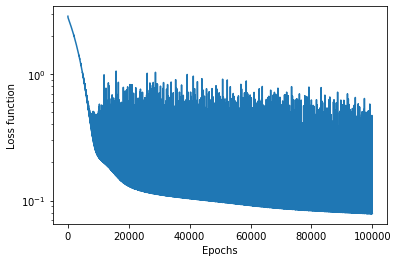

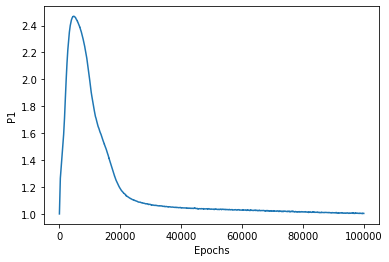

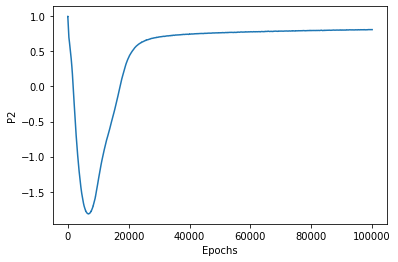

In [ ]:
plt.plot(range(len(Loss_list)), Loss_list, '-')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.yscale('log')
plt.show()
plt.plot(range(len(P1)), P1, '-')
plt.xlabel('Epochs')
plt.ylabel('P1')
plt.show()
plt.plot(range(len(P2)), P2, '-')
plt.xlabel('Epochs')
plt.ylabel('P2')
plt.show()

def predict(X):
    x_star = torch.tensor(X[:, 0:1]/l_c, requires_grad=True).float().to(device)
    y_star = torch.tensor(X[:, 1:2]/l_c, requires_grad=True).float().to(device)

    model.eval()
    u_star, v_star = net_out(x_star, y_star)
    sxx_star, syy_star, sxy_star = net_stress(x_star, y_star)
    u_star = u_star.detach().cpu().numpy()
    v_star = v_star.detach().cpu().numpy()
    sxx_star = sxx_star.detach().cpu().numpy()
    syy_star = syy_star.detach().cpu().numpy()
    sxy_star = sxy_star.detach().cpu().numpy()
    return u_star*u_c, v_star*u_c, sxx_star*sigma_c, syy_star*sigma_c, sxy_star*sigma_c

test_points = np.hstack((train_points, np.zeros(points.shape[0]).reshape(-1,1)))
u_pred, v_pred, sxx_pred, syy_pred, sxy_pred = predict(test_points)

# output to Paraview
pointsToVTK("./2Dring_2f_results", np.ascontiguousarray(test_points[:,0]), np.ascontiguousarray(test_points[:,1]), np.ascontiguousarray(test_points[:,2]), \
                                        data={"U1": u_pred[:,0], "U2": v_pred[:,0], \
                                           "S11": sxx_pred[:,0], "S22": syy_pred[:,0], \
                                           "S12": sxy_pred[:,0]})

f1 = open('2Dring_2f_field.txt', 'w')
for i in range(points.shape[0]):
  f1.write('%.6e %.6e %.6e %.6e %.6e %.6e %.6e \n' %(test_points[i,0], test_points[i,1], u_pred[i,0], v_pred[i,0], sxx_pred[i,0], syy_pred[i,0], sxy_pred[i,0]))
f1.close()

f2 = open('2Dring_2f_loss.txt', 'w')
for i in range(num_train_its-1):
  f2.write('%.6e %.6e %.6e %.6e %.6e %.6e %.6e\n' %(Loss_list[i], Loss_g[i], Loss_i[i], Loss_e1[i], Loss_e2[i], Loss_data[i], Loss_true[i]))
f2.close()

f3 = open('2Dring_2f_force.txt', 'w')
for i in range(num_train_its-1):
  f3.write('%.6e %.6e\n' %(P1[i], P2[i]))
f3.close()

# save pre-trained model
torch.save(model.state_dict(), 'mymodel.pt')